In [29]:
# sky_hotspots.ipynb
# Authors: Stephan Meighen-Berger
# Performs a hotspot check using a density approach

In [30]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pickle
import csv
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm

In [31]:
# picture path
PICS = '../pics/'

In [32]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [33]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [34]:
# Constants
minutes = 60.
days = 60. * 24

In [35]:
def ice_parser(filename):
    store = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row_num, row in enumerate(reader):
            if row_num == 0:
                continue
            store.append(row[0].split())
    store = np.array(store, dtype=float)
    return store

In [36]:
# MJD, log10(E/GeV), AngErr[deg], RA[deg], Dec[deg], Azimuth[deg], Zenith[deg]
data_sets = [
    '../data/icecube_10year_ps/events/IC40_exp.csv',
    '../data/icecube_10year_ps/events/IC59_exp.csv',
    '../data/icecube_10year_ps/events/IC79_exp.csv',
    '../data/icecube_10year_ps/events/IC86_I_exp.csv',
    '../data/icecube_10year_ps/events/IC86_II_exp.csv',
    '../data/icecube_10year_ps/events/IC86_III_exp.csv',
    '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
    '../data/icecube_10year_ps/events/IC86_V_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
    '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
]
event_dic = {
    0: ice_parser(data_sets[0]),
    1: ice_parser(data_sets[1]),
    2: ice_parser(data_sets[2]),
    3: ice_parser(data_sets[3]),
    4: ice_parser(data_sets[4]),
    5: ice_parser(data_sets[5]),
    6: ice_parser(data_sets[6]),
    7: ice_parser(data_sets[7]),
    8: ice_parser(data_sets[8]),
    9: ice_parser(data_sets[9]),
}

C:\Users\steph\AppData\Local\Temp/ipykernel_12752/538871785.py:18: RuntimeWarning: divide by zero encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
C:\Users\steph\AppData\Local\Temp/ipykernel_12752/538871785.py:18: RuntimeWarning: invalid value encountered in true_divide
  weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])


C:\Users\steph\Anaconda3\envs\dmpoint\lib\site-packages\numpy\ma\core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


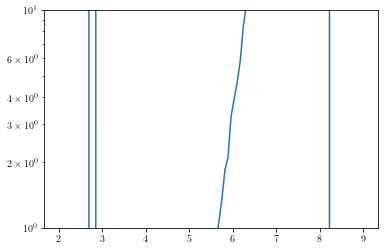

In [37]:
# Loading weights
def weight_constructor(path_to_file: str) -> UnivariateSpline:
    """ constructes the energy weights for the IceCube events

    Parameters
    ----------
    path_to_file : str
        The theoretical preidcitons for the counts

    Returns
    -------
    weights : UnivariateSpline
        Spline which returns the weight corresponding to the input energy
        as log_10(E/GeV)
    """
    theoretical_predictions = pickle.load(open(path_to_file, "rb"))
    egrid = theoretical_predictions[0]
    weights_arr = np.nan_to_num(theoretical_predictions[2] / theoretical_predictions[3])
    # weights_arr[weights_arr > 1] = 1
    return UnivariateSpline(egrid, weights_arr, k=1, s=0)
weights = weight_constructor("..\\data\\simulated_data_bkgrd_store_bckgrd_benchmark.p")
plt.semilogy(np.linspace(2., 9., 100), weights(np.linspace(0., 10., 100)))

In [38]:
def data_filter(event_dic, energy_range, angle_range, years):
    # filters the data in energy and angle
    filtered_dic = {}
    for year in years:
        # where method is faster as basic slicing
        energy_filter_1 = event_dic[year][np.where(event_dic[year][:, 1] < energy_range[1])]
        energy_filter_2 = energy_filter_1[np.where(energy_filter_1[:, 1] > energy_range[0])]
        high_angle = angle_range[1]
        angle_filter_1 = energy_filter_2[np.where(energy_filter_2[:, 4] < high_angle)]
        low_angle = angle_range[0]
        angle_filter_2 = angle_filter_1[np.where(angle_filter_1[:, 4] > low_angle)]
        filtered_dic[year] = angle_filter_2
    return filtered_dic

In [39]:
filtered_data = data_filter(event_dic, [4., 9.], [0., 10.], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
# Construct weighted events
def weighted_events(event_dic, weight_func, years):
    weighted_data = []
    for year in years:
        weighted_data.append(np.array([
            event_dic[year][:, 3],
            event_dic[year][:, 4],
            weight_func(event_dic[year][:, 1]),
            event_dic[year][:, 2]
        ]))
        weighted_data[-1] = weighted_data[-1].T
    return np.concatenate([weighted_data[year] for year in years])
weighted_data = weighted_events(filtered_data, weights, range(10))

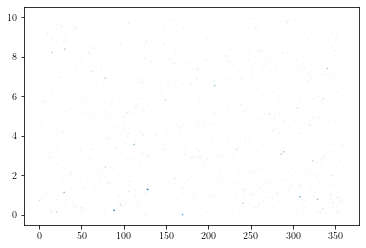

In [41]:
plt.scatter(weighted_data[:, 0], weighted_data[:, 1], s=0.5, alpha=weighted_data[:, 2] / max(weighted_data[:, 2]))

In [42]:
# The sky grid
minimal_resolution = 0.2
ra_grid = np.arange(0., 360., 0.2)
decl_grid = np.arange(0., 10., 0.2)

In [43]:
# Binning function
def binning_function(event_dic, ra_grid, decl_grid):
    # The density grid
    density_grid = np.zeros((len(decl_grid), len(ra_grid)))
    for event in event_dic:
        # Finding grid points to add to
        # RA
        single_ra = False
        idra_low = (np.abs(ra_grid - (event[0] - event[3]))).argmin()
        idra_high = (np.abs(ra_grid - (event[0] + event[3]))).argmin()
        if idra_high == idra_low:
            single_ra = True
        # Declination
        single_dec = False
        iddec_low = (np.abs(decl_grid - (event[1] - event[3]))).argmin()
        iddec_high = (np.abs(decl_grid - (event[1] + event[3]))).argmin()
        if iddec_low == iddec_high:
            single_dec = True
        # Binning
        if (not single_ra) and (not single_dec):
            density_grid[iddec_low:iddec_high, idra_low:idra_high] += event[2]
        elif single_ra and (not single_dec):
            density_grid[iddec_low:iddec_high, idra_low] += event[2]
        elif (not single_ra) and single_dec:
            density_grid[iddec_low, idra_low:idra_high] += event[2]
        else:
            density_grid[iddec_low, idra_low] += event[2]
    return density_grid
density_grid = binning_function(weighted_data, ra_grid, decl_grid)

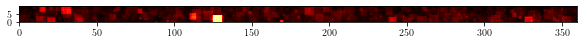

In [44]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(density_grid,
           extent=(np.amin(ra_grid), np.amax(ra_grid),
                   np.amin(decl_grid), np.amax(decl_grid)),
           cmap=cm.hot, origin='lower')
plt.savefig("..\\pics\\heat_map.png", dpi=100)

In [45]:
def coordinate_trafo(radians):
    new_grid = np.copy(radians)
    new_grid[new_grid > np.pi] = new_grid[new_grid > np.pi] - 2. * np.pi
    return new_grid

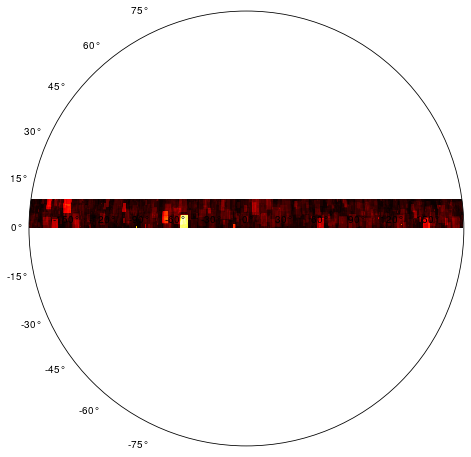

In [46]:
# Using a projection so others have something to look at
fig = plt.figure(figsize=(10, 8))
plt.subplot(projection="mollweide")
traf_RA = coordinate_trafo(np.deg2rad(ra_grid))
plt.imshow(density_grid,
           extent=(np.amin(traf_RA), np.amax(traf_RA),
                   np.amin(np.deg2rad(decl_grid)),
                   np.amax(np.deg2rad(decl_grid))),
           cmap=cm.hot, origin='lower')
plt.savefig("..\\pics\\heat_skymap.png", dpi=100)

In [47]:
# Cummulative distribution
def cummulative_distro(density_grid):
    pcheck = np.linspace(0., 10., 100)
    distro = np.array([
        density_grid[density_grid>elem].shape[0]
        for elem in pcheck
    ])
    return distro, np.mean(density_grid), pcheck
cumm_distro, distro_mean, pcheck = cummulative_distro(density_grid)

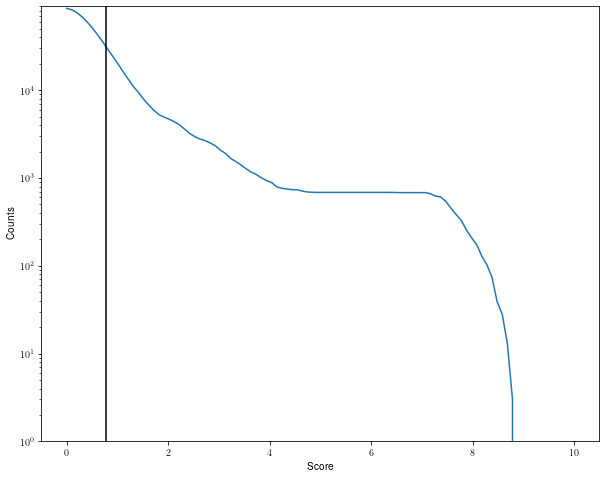

In [48]:
fig = plt.figure(figsize=(10, 8))
plt.semilogy(pcheck, cumm_distro)
plt.axvline(distro_mean, color='k')
plt.xlabel("Score")
plt.ylabel("Counts")
plt.ylim(1., density_grid.size)
plt.savefig("..\\pics\\cummulative_distro.png", dpi=100)

In [49]:
# Comparing distro with background (diffuse)
def scrambled_distro(event_dic, ra_grid, decl_grid, samples=1000):
    # Scramble sets
    ra_scramble_sets = np.random.uniform(0., 360.,
                                         size=(samples, event_dic.shape[0]))
    cumm_distros = []
    distros_means = []
    for sample in tqdm(range(samples)):
        scrambled_sample = np.copy(event_dic)
        scrambled_sample[:, 0] = ra_scramble_sets[sample]  # Scrambled ra
        local_density_grid = binning_function(scrambled_sample,
                                              ra_grid, decl_grid)
        tmp_cumm_distro, tmp_distro_mean, tmp_pcheck = (
            cummulative_distro(local_density_grid)
        )
        cumm_distros.append(tmp_cumm_distro)
        distros_means.append(tmp_distro_mean)
        local_pcheck = tmp_pcheck
    return np.array(cumm_distros), np.array(distros_means), local_pcheck
scram_distros, scram_means, scram_pcheck = scrambled_distro(
    weighted_data, ra_grid, decl_grid, samples=1000
)

100%|██████████| 1000/1000 [01:50<00:00,  9.01it/s]


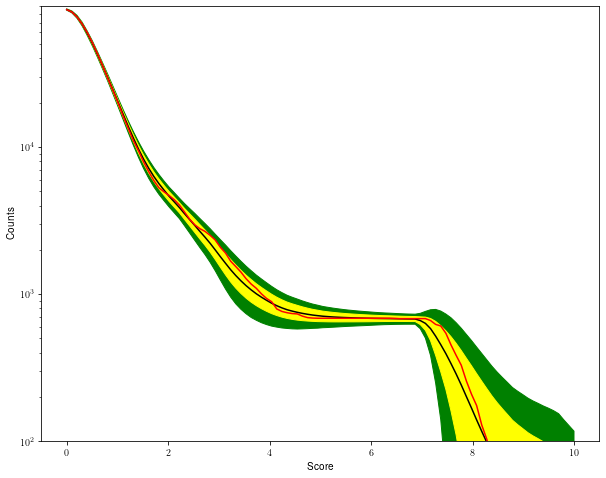

In [50]:
# Comparing to diffuse
fig = plt.figure(figsize=(10, 8))
plt.fill_between(pcheck,
    np.mean(scram_distros, axis=0) - 2. * np.std(scram_distros, axis=0),
    np.mean(scram_distros, axis=0) + 2. * np.std(scram_distros, axis=0),
    color='g'
)
plt.fill_between(pcheck,
    np.mean(scram_distros, axis=0) - np.std(scram_distros, axis=0),
    np.mean(scram_distros, axis=0) + np.std(scram_distros, axis=0),
    color='yellow'
)
plt.plot(pcheck, np.mean(scram_distros, axis=0), color='k')
plt.plot(pcheck, cumm_distro, color='r')
plt.yscale("log")
plt.xlabel("Score")
plt.ylabel("Counts")
plt.ylim(1e2, density_grid.size)
plt.savefig("..\\pics\\cummulative_distro_background.png", dpi=100)

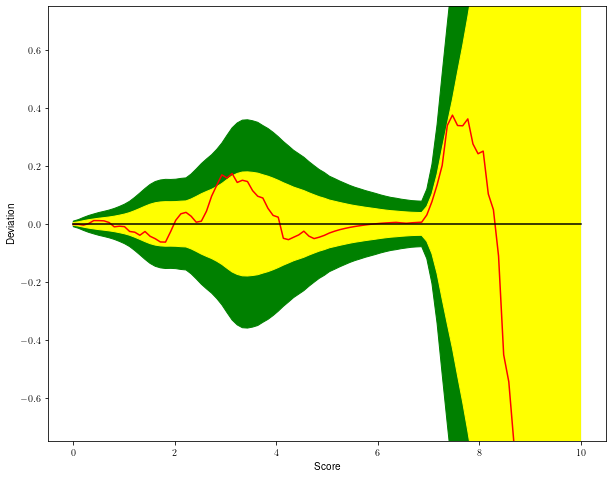

In [51]:
# Deviation from diffuse
fig = plt.figure(figsize=(10, 8))
plt.fill_between(pcheck,
    (np.mean(scram_distros, axis=0) - 2. * np.std(scram_distros, axis=0)) /
    np.mean(scram_distros, axis=0) - 1,
    (np.mean(scram_distros, axis=0) + 2. * np.std(scram_distros, axis=0)) /
    np.mean(scram_distros, axis=0) - 1,
    color='g'
)
plt.fill_between(pcheck,
    (np.mean(scram_distros, axis=0) - np.std(scram_distros, axis=0)) /
    np.mean(scram_distros, axis=0) - 1,
    (np.mean(scram_distros, axis=0) + np.std(scram_distros, axis=0)) /
    np.mean(scram_distros, axis=0) - 1,
    color='yellow'
)
plt.plot(pcheck, cumm_distro / np.mean(scram_distros, axis=0) - 1, color='r')
plt.plot(pcheck, np.mean(scram_distros, axis=0) /
                 np.mean(scram_distros, axis=0) - 1, color='k')
plt.yscale("linear")
plt.xlabel("Score")
plt.ylabel("Deviation")
plt.ylim(-0.75, 0.75)
plt.savefig("..\\pics\\cummulative_distro_background_ratio.png", dpi=100)

In [52]:
# Improving the comparison by including the position information of the skymap
def data_generator(event_dic, ra_grid, decl_grid, samples=1000,
                   setsize=1000):
    # Scramble set
    sets = int(samples / setsize)
    for set_id in tqdm(range(sets)):
        rand_state = np.random.RandomState(set_id)
        ra_scramble_sets = rand_state.uniform(
            0., 360., size=(setsize, event_dic.shape[0])
        )
        density_sets = []
        for subset in range(setsize):
            scrambled_sample = np.copy(event_dic)
            scrambled_sample[:, 0] = ra_scramble_sets[subset]  # Scrambled ra
            local_density_grid = binning_function(scrambled_sample,
                                                ra_grid, decl_grid)
            density_sets.append(local_density_grid)
        pickle.dump(density_sets,
            open("..\\data\\storage\\density_sets_%d.p" % set_id, "wb")
        )
def improved_comparison(data, samples=1000,
                        setsize=1000):
    sets = int(samples / setsize)
    totals = []
    for set_id in tqdm(range(sets)):
        density_sets = pickle.load(
            open("..\\data\\storage\\density_sets_%d.p" % set_id, "rb")
        )
        tmp_total = np.zeros_like(density_sets[0])
        for density_set in density_sets:
            tmp_total += density_set
        tmp_total = tmp_total / setsize
        totals.append(tmp_total)
    average_density = np.zeros_like(totals[0])
    for total in totals:
        average_density += total
    average_density = average_density / sets  # Normalized
    chi2_data = np.sum(np.nan_to_num(
        (data - average_density)**2. / average_density
    ))
    lower_than_data = 0.
    for set_id in tqdm(range(sets)):
        density_sets = pickle.load(
            open("..\\data\\storage\\density_sets_%d.p" % set_id, "rb")
        )
        # Comparing to the scrambled data
        chi2_bkgrd_set = np.array([
        np.sum(
                np.nan_to_num((density_set - average_density)**2. / average_density)
            )
            for density_set in density_sets
        ])
        lower_than_data += len(chi2_bkgrd_set[chi2_bkgrd_set <= chi2_data])
    print("Score Data: %.1e" %chi2_data)
    print(lower_than_data)
    cl_lim = lower_than_data / float(samples)
    print(cl_lim)
    return chi2_data, cl_lim

In [53]:
set_size = 1000
samples = 100000
data_generator(weighted_data, ra_grid, decl_grid, samples=samples,
               setsize=set_size)

100%|██████████| 100/100 [2:58:42<00:00, 107.22s/it]


In [54]:
chi2_data, cl_lim = (
    improved_comparison(density_grid, samples=samples, setsize=set_size)
)

100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Score Data: 7.9e+04
69253.0
0.69253
